In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
from tqdm import tqdm
import random, math, ast

In [2]:
credits = pd.read_csv('../dataset/credits.csv')
keywords = pd.read_csv('../dataset/keywords.csv')
links = pd.read_csv('../dataset/links_small.csv')
md = pd.read_csv('../dataset/movies_metadata.csv')
ratings = pd.read_csv('../dataset/ratings_small.csv')

/var/folders/wy/xyqwny610cb9ft3dhglx4jyc0000gn/T/ipykernel_9113/949808799.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('../dataset/movies_metadata.csv')


## Use sample of movies:
add also a custom user

In [4]:
test_user = pd.DataFrame({'userId': [800,800,800,800,800,800,800], 'movieId': [372058, 550, 129, 101, 27205, 11976, 11052], 'rating': [5, 4.8, 5, 4.5, 5, 3.8 , 1], 'timestamp': ratings['timestamp'][:7].values})
ratings = pd.concat((ratings, test_user))

In [5]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(
    ratings[['userId', 'movieId', 'rating']],
    reader
)

In [11]:
param_grid = {'n_epochs': [5, 10, 20, 40, 50, 100],
              'lr_all': [0.03, 0.01, 0.007, 0.005, 0.003, 0.001, 0.0005, 0.0001]}

gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=3,
                  n_jobs=-1,
                  joblib_verbose=True)

In [13]:
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   19.3s finished


In [15]:
gs.best_score['rmse']

0.9029267500680805

In [17]:
gs.best_params['rmse']

{'n_epochs': 20, 'lr_all': 0.005}

In [19]:
svd_model = SVD(**gs.best_params['rmse'])
data = data.build_full_trainset()
svd_model.fit(data)

In [21]:
out = svd_model.predict(uid=67, iid=862, verbose=True)
out

user: 800        item: 862        r_ui = None   est = 3.78   {'was_impossible': False}


Prediction(uid=800, iid=862, r_ui=None, est=3.7797817233804345, details={'was_impossible': False})

In [55]:
out = []
for idx in ratings['movieId'].unique():
    _, iid, _, est, _ = svd_model.predict(uid=800, iid=idx)
    out.append((iid, est))

In [51]:
pd.DataFrame(out).sort_values(by=1, ascending=False).rename({0: 'movieId', 1: 'rating'}, axis=1)

,movieId,rating
157,858,4.816553
736,912,4.772435
631,7502,4.732706
328,1221,4.730216
158,903,4.718024
...,...,...
4254,2380,2.441619
3128,2153,2.406345
4210,546,2.343723
821,1556,2.308215


## Evaluation

In [91]:
def precision_at_k(recommended, relevant_set, k):
    return (len([i for i in recommended[:k] if i in relevant_set]) / k) * 100

def recall_at_k(recommended, relevant_set, k):
    return (len([i for i in recommended[:k] if i in relevant_set]) / len(relevant_set)) * 100 if relevant_set else 0.0

def hit_rate_at_k(recommended, relevant_set, k):
    return 1.0 if any(i in relevant_set for i in recommended[:k]) else 0.0

def average_precision_at_k(recommended, relevant_set, k):
    ap, hit = 0.0, 0
    for i, item in enumerate(recommended[:k], start=1):
        if item in relevant_set:
            hit += 1
            ap += hit / i
    return (ap / min(len(relevant_set), k)) * 100 if hit > 0 else 0.0

def ndcg_at_k(recommended, relevant_set, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k], start=1):
        if item in relevant_set:
            dcg += 1.0 / math.log2(i + 1)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, min(len(relevant_set), k) + 1))
    return dcg / idcg if idcg > 0 else 0.0


In [93]:
ratings = ratings.sort_values(["userId","timestamp"])
last_idx = ratings.groupby("userId")["timestamp"].idxmax()
test_df = ratings.loc[last_idx]
train_df = ratings.drop(last_idx)

test_df = test_df[test_df['userId'].isin(train_df['userId'])]
print(f"Train: {len(train_df)}, Test: {len(test_df)} users={test_df['userId'].nunique()}")

Train: 99342, Test: 676 users=672


In [67]:
reader = Reader(rating_scale=(ratings.rating.min(), ratings.rating.max()))
data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)
trainset = data.build_full_trainset()

svd = SVD()
svd.fit(trainset)

In [95]:
Ks = [3, 5, 10, 20]
metrics = {k:{'precision':[],'recall':[],'hr':[],'map':[],'ndcg':[]} for k in Ks}

all_items = set(ratings.movieId.unique())
train_items_by_user = train_df.groupby("userId")["movieId"].apply(set).to_dict()
item_pop = Counter(train_df.movieId)
total_inter = len(train_df)

recommended_global = set()
novelty_sum, user_count = 0.0, 0

for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    user, pos_item = row['userId'], row['movieId']
    train_items = train_items_by_user[user]

    candidates = list(all_items - train_items - {pos_item})
    if len(candidates) > 1000:  # sample negatives
        candidates = random.sample(candidates, 1000)
    candidates.append(pos_item)

    preds = [(iid, svd.predict(user, iid).est) for iid in candidates]
    ranked = [iid for iid,_ in sorted(preds, key=lambda x:x[1], reverse=True)]
    relevant = {pos_item}

    for k in Ks:
        metrics[k]['precision'].append(precision_at_k(ranked,relevant,k))
        metrics[k]['recall'].append(recall_at_k(ranked,relevant,k))
        metrics[k]['hr'].append(hit_rate_at_k(ranked,relevant,k))
        metrics[k]['map'].append(average_precision_at_k(ranked,relevant,k))
        metrics[k]['ndcg'].append(ndcg_at_k(ranked,relevant,k))

    topk = ranked[:max(Ks)]
    recommended_global.update(topk)

    # novelty (self-information based on popularity)
    novelty_sum += np.mean([-math.log2((item_pop.get(i,0)+1e-9)/total_inter) for i in topk])
    user_count+=1

100%|██████████████████████████████████████████████████████████████████████████████████████████| 676/676 [00:01<00:00, 376.67it/s]


In [97]:
agg = {}
for k in Ks:
    agg[k] = {m:np.mean(vals) for m,vals in metrics[k].items()}

catalog_coverage = len(recommended_global)/len(all_items)
novelty = novelty_sum/user_count

print("Ranking Metrics:")
for k in Ks:
    print(f"K={k} -> {agg[k]}")
print("\nBeyond Accuracy:")
print(f"Catalog Coverage={catalog_coverage:.4f}, Novelty={novelty:.4f}")

Ranking Metrics:
K=3 -> {'precision': 1.2327416173570016, 'recall': 3.698224852071006, 'hr': 0.03698224852071006, 'map': 2.8353057199211045, 'ndcg': 0.03058930145287444}
K=5 -> {'precision': 0.9467455621301775, 'recall': 4.733727810650888, 'hr': 0.047337278106508875, 'map': 3.0719921104536487, 'ndcg': 0.03485448585227857}
K=10 -> {'precision': 0.7692307692307693, 'recall': 7.6923076923076925, 'hr': 0.07692307692307693, 'map': 3.456959706959707, 'ndcg': 0.04431791606254736}
K=20 -> {'precision': 0.658284023668639, 'recall': 13.165680473372781, 'hr': 0.13165680473372782, 'map': 3.8161992335719592, 'ndcg': 0.05789309329832222}

Beyond Accuracy:
Catalog Coverage=0.1396, Novelty=11.5050


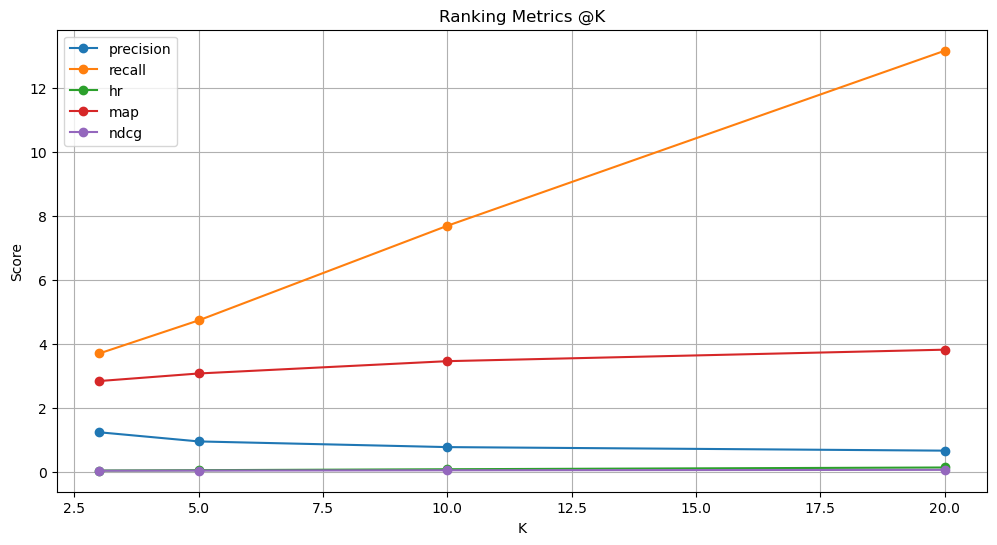

In [103]:
import matplotlib.pyplot as plt

Ks = sorted(agg.keys())
metrics_names = list(next(iter(agg.values())).keys())

plt.figure(figsize=(12,6))
for m in metrics_names:
    plt.plot(Ks, [agg[k][m] for k in Ks], marker='o', label=m)

plt.title("Ranking Metrics @K")
plt.xlabel("K")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()